In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns

#sklearn libraries
from sklearn.model_selection import train_test_split

#keras packages
import keras
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

#cnn model 
from keras.layers import Conv2D , MaxPool2D, AveragePooling2D, BatchNormalization, Dense,Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam


#model fit
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [2]:
#define the root directory
root_dir = "../input/cat-and-dog/training_set/training_set"
folders = os.listdir(root_dir)
print(folders)

['dogs', 'cats']


In [3]:
# prepare training  data
#labeling dogs -- 0 cats -- 1

#use image size as 200 X 200
target_size = (144,144)

def prepare_training_data(root_dir,folders):
    X,y = [],[]
    
    label = 0 # starting with dogs
    
    for dir_name in folders:
        print("preparing the directory---------------------------->",dir_name)
        path = os.path.join(root_dir,dir_name)
        print(path)
        for pic in os.listdir(path):
            if str(pic) != "_DS_Store":
                img = image.load_img(path + '/' + pic ,target_size = target_size)
                img_arr = image.img_to_array(img , data_format="channels_last")
                img_arr = img_arr.astype("float32")
                X.append(img_arr)
                y.append(int(label))
            
        label += 1 # next for cats
    
    X = np.array(X)
    y = np.array(y)
    print("preparation Complated..............")
    return X,y
    
X_train,y_train = prepare_training_data(root_dir,folders)

preparing the directory----------------------------> dogs
../input/cat-and-dog/training_set/training_set/dogs
preparing the directory----------------------------> cats
../input/cat-and-dog/training_set/training_set/cats
preparation Complated..............


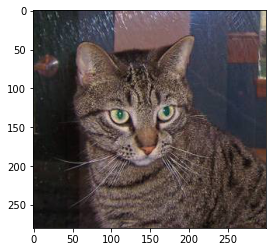

In [4]:
img = plt.imread('../input/cat-and-dog/training_set/training_set/cats/cat.1.jpg')
plt.imshow(img)

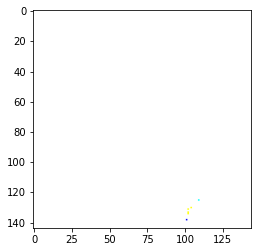

In [5]:
plt.imshow(X_train[0])

## Test data preparation

In [6]:
root_dir_test = '../input/cat-and-dog/test_set/test_set'
folder_test = os.listdir(root_dir_test)
print(folder_test)

['dogs', 'cats']


In [7]:
# prepare the test data 
#there is not need for label it so litely changed the code

target_size = (144,144)

def prepare_test_data(root_dir,folders):
    X = []
    
    
    for dir_name in folders:
        print("preparing the directory---------------------------->",dir_name)
        path = os.path.join(root_dir,dir_name)
        print(path)
        for pic in os.listdir(path):
            if str(pic) != "_DS_Store":
                img = image.load_img(path + '/' + pic ,target_size = target_size)
                img_arr = image.img_to_array(img , data_format="channels_last")
                img_arr = img_arr.astype("float32")
                X.append(img_arr)
        
    X = np.array(X)
    
    print("preparation Completed!!!..............")
    return X
    
test = prepare_test_data(root_dir_test,folder_test)

preparing the directory----------------------------> dogs
../input/cat-and-dog/test_set/test_set/dogs
preparing the directory----------------------------> cats
../input/cat-and-dog/test_set/test_set/cats
preparation Completed!!!..............


## 2) Preprocessing the Data

2.1) check for null values<br>
2.2) Normalization <br>
2.3) One hot encoding (Target) <br>
2.4) Split the data(train and validation)  <br>
2.5) Data Agumentation <br>

### Check for null values.
If there any null vales means , you have fill it with correct data or leave it.

In [8]:
# merge that two things for check is there any null values
train = pd.DataFrame([X_train,y_train])
train.isnull().any().sum()

0

In [9]:
train.isnull().any().describe()

count         1
unique        1
top       False
freq          1
dtype: object

## Normalization
scaling is utilised to reduce the effect of illumination differences and to increase the efficiency of the training.

In [10]:
X_train = (X_train)/255.0
test = (test)/255.0

## One hot Encoding the target

change the target like 1 to -->[0,1] and --> [1,0]
This was a binary classification task,so no neef for one hot encoding

In [11]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [31]:
y_train = to_categorical(y_train,2)

## Split the data

In [32]:
# set the random seed
random_seed =2 

In [33]:
#split the data
X_train , X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2, random_state =random_seed )

In [34]:
print("The size of the train data",X_train.shape)
print("The size of the train target data",y_train.shape)
print("The size of the validation data",X_val.shape)
print("The size of the validation target data",y_val.shape)

The size of the train data (5123, 144, 144, 3)
The size of the train target data (5123, 2)
The size of the validation data (1281, 144, 144, 3)
The size of the validation target data (1281, 2)


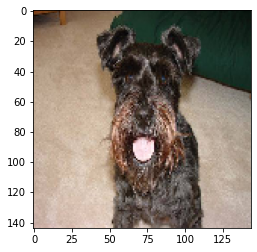

In [35]:
plt.imshow(X_train[0])

## Data Agumentation

In [36]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

# 3)Build the model
This is a basic CNN model 3 Conve layer and one 1 dense layer and 1 final dense layer for output 

In [53]:
model = Sequential()

#block 1
model.add(Conv2D(filters = 32, kernel_size = (5,5), input_shape = (144,144,3), padding='same',activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))

#block2
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding='same',activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))
#block 3
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same',activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))

#block 4
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same',activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))
#flatten layer
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

#final layer
model.add(Dense(2,activation = 'sigmoid'))

## 3.1) Configure and Compile the model
1) set the optimizer<br>
2) set the loss function---this is a binary classification prolem so use 'binary_crossentropy'<br>
3)set the metrics<br>

In [54]:
optimizer = Adam (lr=0.001, beta_1=0.9, beta_2=0.999 )

loss = 'binary_crossentropy'

metric = ['accuracy']


In [55]:
#Compiling the model
model.compile(optimizer=optimizer, loss= loss, metrics=metric)

In [56]:
#see the summary of the model

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 144, 144, 32)      2432      
_________________________________________________________________
batch_normalization_18 (Batc (None, 144, 144, 32)      128       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 32)        25632     
_________________________________________________________________
batch_normalization_19 (Batc (None, 72, 72, 32)        128       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 36, 36, 32)       

In [57]:
X_train[0].shape

(144, 144, 3)

## 3.2)Early Stoping

In [58]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           min_delta=0.001, # minimium amount of change to count as an improvement
                           patience=20, # how many epochs to wait before stopping
                            restore_best_weights=True,)

## 3.3)Reduce Learning Rate

In [59]:
learning_rate_reduce = ReduceLROnPlateau(moniter='val_loss',
                                        verbose= 1,
                                        min_lr = 0.00001,
                                        factor= 5e-7,
                                        patience = 4)

## Fit the model


In [60]:
epochs = 35
batch_size = 64

In [ ]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,y_val),
                              verbose = 1, 
                               
                              callbacks=[early_stop , learning_rate_reduce],
                              )

Epoch 1/35
81/81 [==============================] - 24s 298ms/step - loss: 0.8646 - accuracy: 0.6075 - val_loss: 0.6844 - val_accuracy: 0.5777
Epoch 2/35
17/81 [=====>........................] - ETA: 17s - loss: 0.6885 - accuracy: 0.6443